# Imports

In [1]:
import scipy.io
import numpy as np
import pandas as pd
import os
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm


# Ignore all warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
meta_path = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_meta.mat"
train_annos_path = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_train_annos.mat"

meta = scipy.io.loadmat(meta_path)
raw_classes = meta['class_names'].flatten()
class_names = [i.item() for i in raw_classes]

train_annos = scipy.io.loadmat(train_annos_path)
raw_annos = train_annos['annotations'][0]

data = []
for sample in raw_annos:
    fname = sample['fname'].item()
    class_id = sample['class'].item()
    class_name = class_names[class_id - 1]
    x1 = sample['bbox_x1'].item()
    y1 = sample['bbox_y1'].item()
    x2 = sample['bbox_x2'].item()
    y2 = sample['bbox_y2'].item()
    data.append([fname, class_id, class_name, x1, y1, x2, y2])

df_train = pd.DataFrame(data, columns=['filename', 'class_id', 'class_name', 'x1', 'y1', 'x2', 'y2'])
print(f"Total Images: {len(df_train)}")
print(f"Total Classes: {len(class_names)}")

Total Images: 8144
Total Classes: 196


In [3]:
class StanfordCarsDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        
        image = image.crop((row['x1'], row['y1'], row['x2'], row['y2']))
        
        label = int(row['class_id']) - 1
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Pre-processing

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
images_root = '/kaggle/input/stanford-cars-dataset/cars_train/cars_train'

# Split: 70% Train, 15% Val, 15% Test
train_df, test_df1 = train_test_split(
    df_train, 
    test_size=0.3, 
    random_state=42, 
    stratify=df_train['class_id']
)

test_df, val_df = train_test_split(
    test_df1, 
    test_size=0.5, 
    random_state=42, 
    stratify=test_df1['class_id']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

# Create datasets
train_ds = StanfordCarsDataset(train_df, images_root, transform=train_transforms)
val_ds = StanfordCarsDataset(val_df, images_root, transform=test_transforms)  # Fix #2
test_ds = StanfordCarsDataset(test_df, images_root, transform=test_transforms)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

Training samples: 5700
Validation samples: 1222
Testing samples: 1222


# Model Implementation

In [6]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=in_channels,
            bias=False #turned off since the btach norm will add bias
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn1(x)
        x = F.relu6(x) # orignial paper uses relu6
        
        x = self.pointwise(x)
        x = self.bn2(x)
        x = F.relu6(x)
        return x


class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.dw_conv2 = DepthwiseSeparableConv(32, 64, 1)
        self.dw_conv3 = DepthwiseSeparableConv(64, 128, 2)
        self.dw_conv4 = DepthwiseSeparableConv(128, 128, 1)
        self.dw_conv5 = DepthwiseSeparableConv(128, 256, 2)
        self.dw_conv6 = DepthwiseSeparableConv(256, 256, 1)
        self.dw_conv7 = DepthwiseSeparableConv(256, 512, 2)
        
        self.dw_conv8 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv9 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv10 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv11 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv12 = DepthwiseSeparableConv(512, 512, 1)
        
        self.dw_conv13 = DepthwiseSeparableConv(512, 1024, 2)
        self.dw_conv14 = DepthwiseSeparableConv(1024, 1024, 1)
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.dw_conv2(x)
        x = self.dw_conv3(x)
        x = self.dw_conv4(x)
        x = self.dw_conv5(x)
        x = self.dw_conv6(x)
        x = self.dw_conv7(x)
        x = self.dw_conv8(x)
        x = self.dw_conv9(x)
        x = self.dw_conv10(x)
        x = self.dw_conv11(x)
        x = self.dw_conv12(x)
        x = self.dw_conv13(x)
        x = self.dw_conv14(x)
        
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Model Prep

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MobileNet(len(class_names));
model = model.to(device)
assert model.fc.out_features == len(class_names), "Model output doesn't match number of classes!"
print(f"Model ready: MobileNet V1 for {len(class_names)} classes")

Using device: cuda
Model ready: MobileNet V1 for 196 classes


In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='best_checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
    
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss improved. Saving model...')

In [9]:
def mixup_data(x, y, alpha=0.2):
    """Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Training

In [10]:
print("\n" + "="*70)
print("Training MobileNet")
print("="*70)

num_epochs = 30

for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
early_stopper = EarlyStopping(patience=5, min_delta=0, path='mobilenet_best.pth')


for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    
    model.train()
    train_loss = 0
    train_correct = 0
    
    loop = tqdm(train_loader, desc="Training")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        
        loop.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    scheduler.step()
    
    early_stopper(avg_val_loss, model)
    
    if early_stopper.early_stop:
        print("Early stopping triggered!")
        break

model.load_state_dict(torch.load('mobilenet_best.pth'))
print("\nTraining complete. Loaded best weights.")


Training MobileNet

=== Epoch 1/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.3913 | Train Acc: 0.0063
Val Loss:   5.1660 | Val Acc:   0.0098
Validation loss improved. Saving model...

=== Epoch 2/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.1175 | Train Acc: 0.0125
Val Loss:   5.1481 | Val Acc:   0.0139
Validation loss improved. Saving model...

=== Epoch 3/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.9250 | Train Acc: 0.0204
Val Loss:   4.8382 | Val Acc:   0.0295
Validation loss improved. Saving model...

=== Epoch 4/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.6773 | Train Acc: 0.0330
Val Loss:   4.6227 | Val Acc:   0.0376
Validation loss improved. Saving model...

=== Epoch 5/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.3876 | Train Acc: 0.0533
Val Loss:   4.2809 | Val Acc:   0.0687
Validation loss improved. Saving model...

=== Epoch 6/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.0517 | Train Acc: 0.0898
Val Loss:   3.8962 | Val Acc:   0.0908
Validation loss improved. Saving model...

=== Epoch 7/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.7251 | Train Acc: 0.1161
Val Loss:   3.7505 | Val Acc:   0.1334
Validation loss improved. Saving model...

=== Epoch 8/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.4016 | Train Acc: 0.1775
Val Loss:   3.3964 | Val Acc:   0.1718
Validation loss improved. Saving model...

=== Epoch 9/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.0647 | Train Acc: 0.2296
Val Loss:   3.0858 | Val Acc:   0.2316
Validation loss improved. Saving model...

=== Epoch 10/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.7207 | Train Acc: 0.2921
Val Loss:   2.7574 | Val Acc:   0.2946
Validation loss improved. Saving model...

=== Epoch 11/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.8951 | Train Acc: 0.4863
Val Loss:   2.2870 | Val Acc:   0.3846
Validation loss improved. Saving model...

=== Epoch 14/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.6471 | Train Acc: 0.5465
Val Loss:   2.0769 | Val Acc:   0.4468
Validation loss improved. Saving model...

=== Epoch 15/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.4446 | Train Acc: 0.6009
Val Loss:   1.9938 | Val Acc:   0.4787
Validation loss improved. Saving model...

=== Epoch 16/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.2779 | Train Acc: 0.6440
Val Loss:   1.8691 | Val Acc:   0.5131
Validation loss improved. Saving model...

=== Epoch 17/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.1344 | Train Acc: 0.6851
Val Loss:   1.7737 | Val Acc:   0.5295
Validation loss improved. Saving model...

=== Epoch 18/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.9750 | Train Acc: 0.7372
Val Loss:   1.7077 | Val Acc:   0.5556
Validation loss improved. Saving model...

=== Epoch 19/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.8641 | Train Acc: 0.7642
Val Loss:   1.6118 | Val Acc:   0.5663
Validation loss improved. Saving model...

=== Epoch 20/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.7585 | Train Acc: 0.7949
Val Loss:   1.5967 | Val Acc:   0.5745
Validation loss improved. Saving model...

=== Epoch 21/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.6780 | Train Acc: 0.8221
Val Loss:   1.5294 | Val Acc:   0.5867
Validation loss improved. Saving model...

=== Epoch 22/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.6043 | Train Acc: 0.8465
Val Loss:   1.5124 | Val Acc:   0.6080
Validation loss improved. Saving model...

=== Epoch 23/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.5383 | Train Acc: 0.8691
Val Loss:   1.4720 | Val Acc:   0.6080
Validation loss improved. Saving model...

=== Epoch 24/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.4880 | Train Acc: 0.8821
Val Loss:   1.4515 | Val Acc:   0.6219
Validation loss improved. Saving model...

=== Epoch 25/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.4537 | Train Acc: 0.8925
Val Loss:   1.4214 | Val Acc:   0.6219
Validation loss improved. Saving model...

=== Epoch 26/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.4188 | Train Acc: 0.9030
Val Loss:   1.4260 | Val Acc:   0.6203
EarlyStopping counter: 1 out of 5

=== Epoch 27/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.3953 | Train Acc: 0.9123
Val Loss:   1.3982 | Val Acc:   0.6342
Validation loss improved. Saving model...

=== Epoch 28/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.3801 | Train Acc: 0.9202
Val Loss:   1.4097 | Val Acc:   0.6277
EarlyStopping counter: 1 out of 5

=== Epoch 29/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.3659 | Train Acc: 0.9193
Val Loss:   1.3998 | Val Acc:   0.6252
EarlyStopping counter: 2 out of 5

=== Epoch 30/30 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.3689 | Train Acc: 0.9182
Val Loss:   1.4290 | Val Acc:   0.6170
EarlyStopping counter: 3 out of 5

Training complete. Loaded best weights.


In [11]:
def evaluate_model(model, loader, device):
    model.eval()
    
    correct_1 = 0
    correct_5 = 0
    total = 0
    
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # --- Top-1 Accuracy ---
            _, pred_1 = torch.max(outputs, 1)
            correct_1 += (pred_1 == labels).sum().item()
            
            # --- Top-5 Accuracy ---
            _, pred_5 = outputs.topk(5, 1, largest=True, sorted=True)
            
            correct_5 += (pred_5 == labels.view(-1, 1)).sum().item()
            
            total += labels.size(0)
            
            all_preds.extend(pred_1.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    top1_acc = correct_1 / total
    top5_acc = correct_5 / total
    
    return top1_acc, top5_acc, all_labels, all_preds


device = torch.device("cuda")
model.load_state_dict(torch.load('mobilenet_best.pth'))
acc_1, acc_5, y_true, y_pred = evaluate_model(model, test_loader, device)

print("-" * 30)
print(f"Top-1 Accuracy: {acc_1*100:.2f}%")
print(f"Top-5 Accuracy: {acc_5*100:.2f}%")
print("-" * 30)

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

------------------------------
Top-1 Accuracy: 65.06%
Top-5 Accuracy: 87.40%
------------------------------


In [12]:
from sklearn.metrics import classification_report

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


DETAILED CLASSIFICATION REPORT
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.6667    0.8571    0.7500         7
                                   Acura RL Sedan 2012     0.5714    0.8000    0.6667         5
                                   Acura TL Sedan 2012     0.7500    1.0000    0.8571         6
                                  Acura TL Type-S 2008     0.3077    0.6667    0.4211         6
                                  Acura TSX Sedan 2012     0.8000    0.6667    0.7273         6
                             Acura Integra Type R 2001     0.6000    0.5000    0.5455         6
                              Acura ZDX Hatchback 2012     1.0000    0.8333    0.9091         6
              Aston Martin V8 Vantage Convertible 2012     1.0000    0.2857    0.4444         7
                    Aston Martin V8 Vantage Coupe 2012     0.2857    0.3333    0.3077         6
       


SAMPLE MISCLASSIFICATIONS


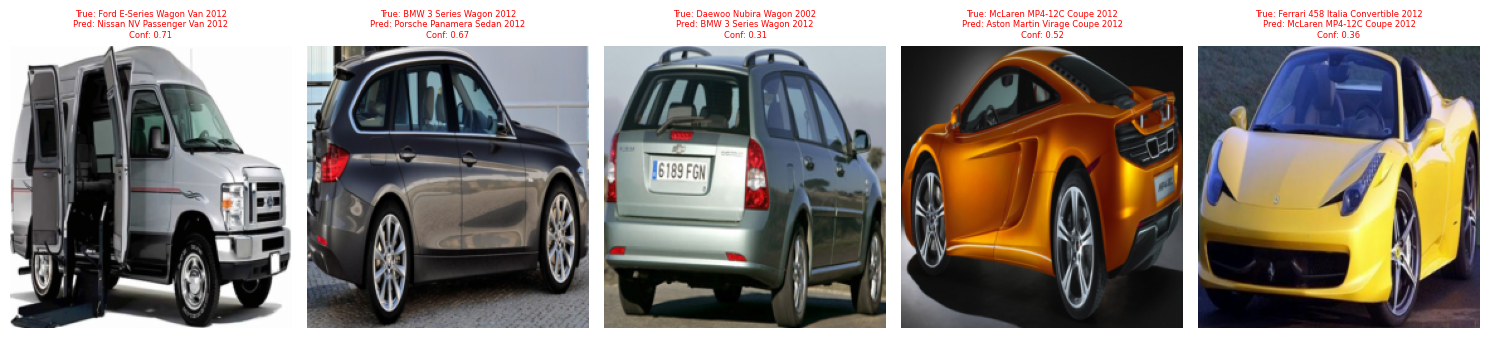

In [13]:
import matplotlib.pyplot as plt

def visualize_failures(model, loader, device, num_images=5):
    model.eval()
    images_shown = 0
    
    plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs, preds = torch.max(torch.softmax(outputs, dim=1), 1)
            
            for i in range(len(images)):
                if preds[i] != labels[i]:
                    if images_shown >= num_images:
                        plt.tight_layout()
                        plt.show()
                        return
                    
                    # Undo normalization
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
                    img = np.clip(img, 0, 1)
                    
                    true_name = class_names[labels[i].item()]
                    pred_name = class_names[preds[i].item()]
                    confidence = probs[i].item()
                    
                    ax = plt.subplot(1, num_images, images_shown + 1)
                    plt.imshow(img)
                    plt.title(f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.2f}", 
                             fontsize=6, color='red')
                    plt.axis('off')
                    
                    images_shown += 1
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("SAMPLE MISCLASSIFICATIONS")
print("="*70)
visualize_failures(model, test_loader, device, num_images=5)

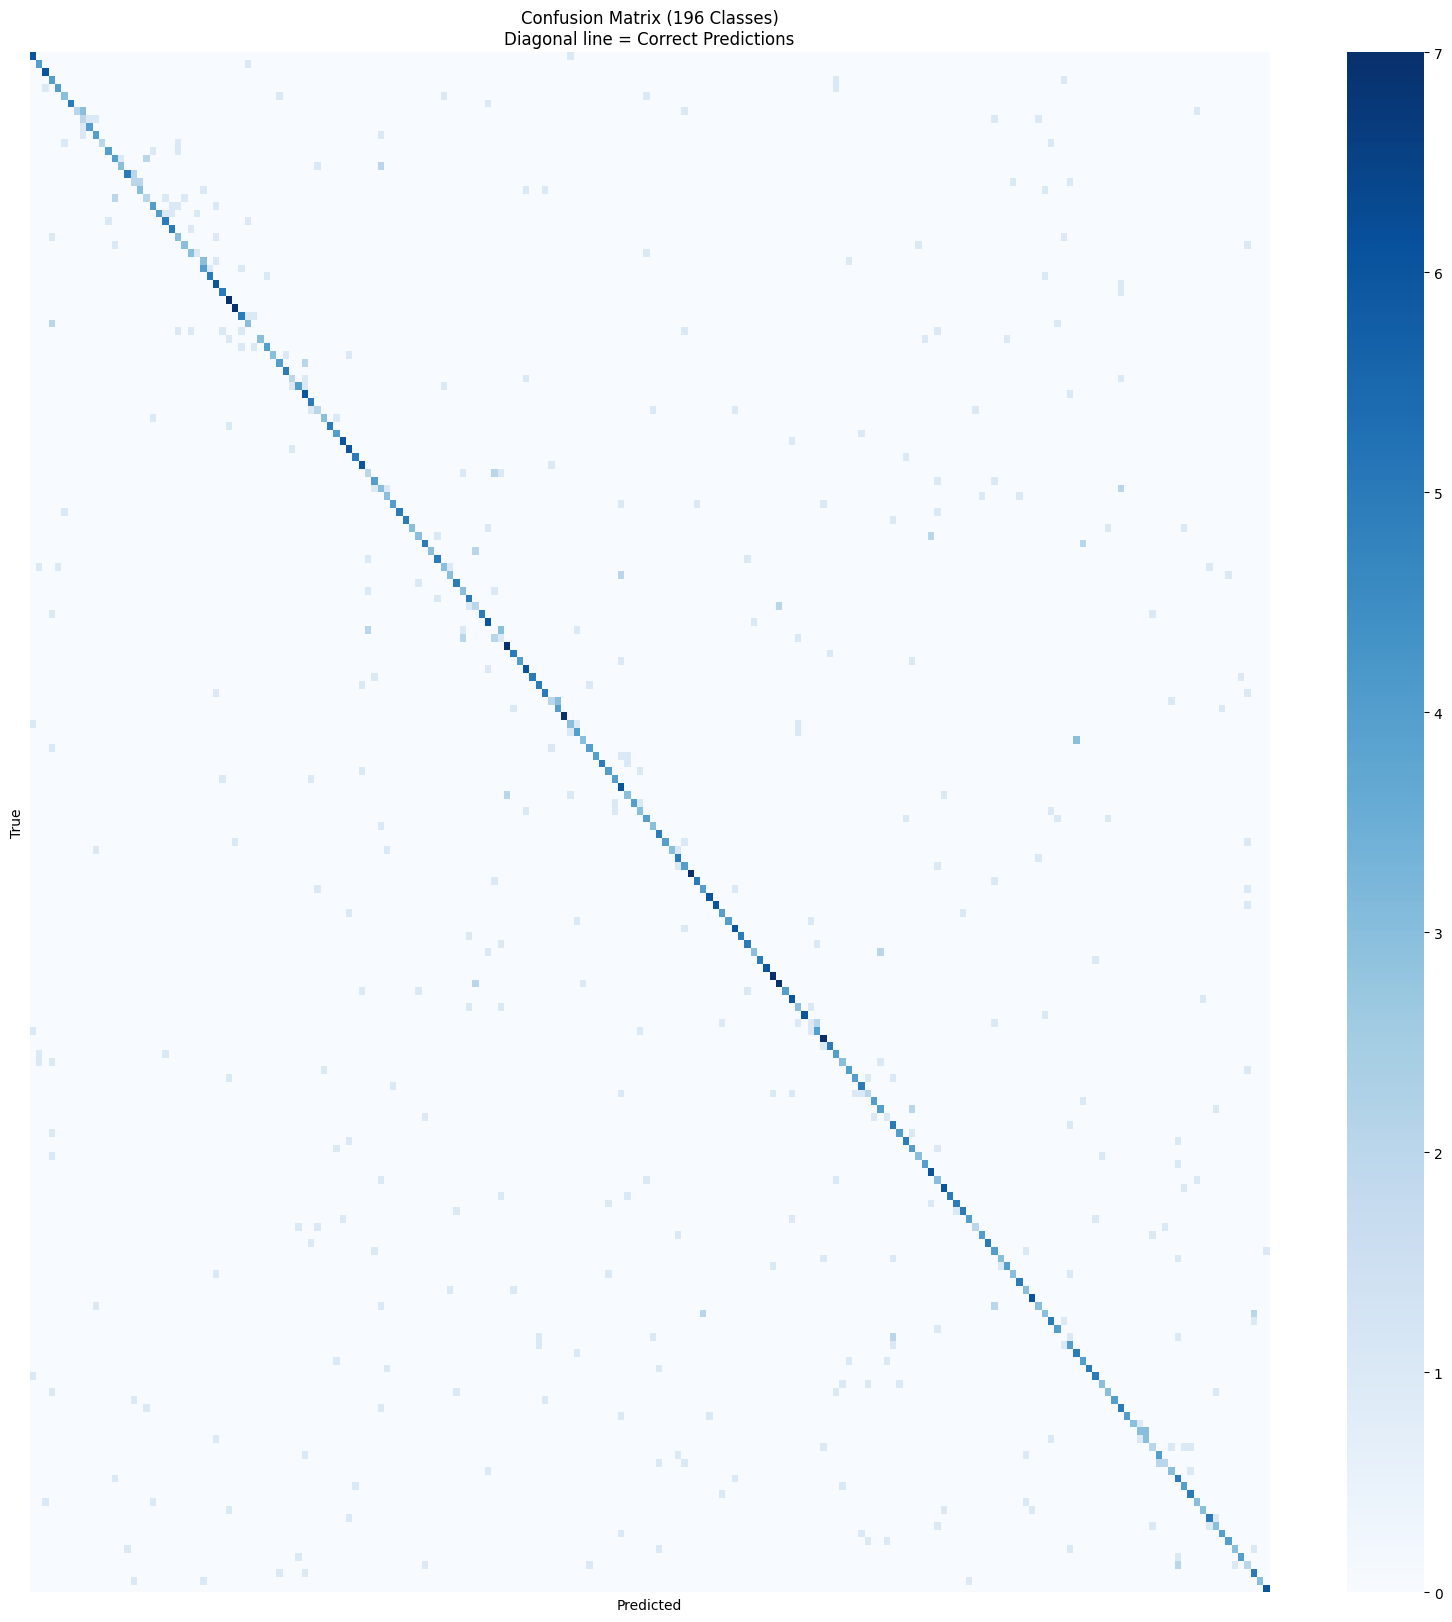

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=False, yticklabels=False) # Labels hidden for clarity

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (196 Classes)\nDiagonal line = Correct Predictions')
plt.show()

Getting Probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

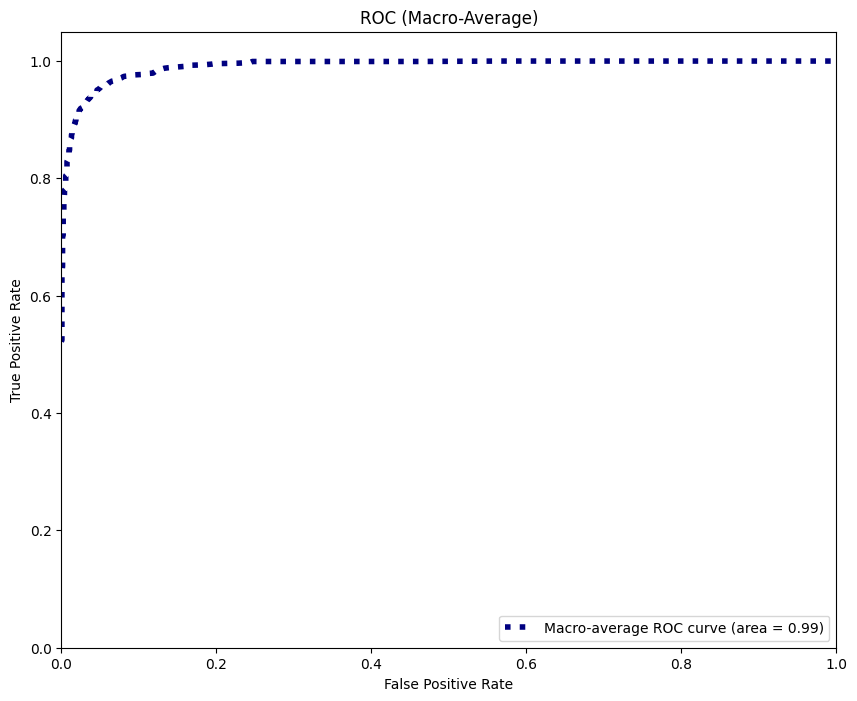

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def get_all_probs(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Getting Probabilities"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1) # Convert logits to probabilities
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
            
    return np.concatenate(all_probs), np.concatenate(all_labels)

y_probs, y_test_np = get_all_probs(model, test_loader, device)

n_classes = len(class_names)
y_test_bin = label_binarize(y_test_np, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Macro-Average)')
plt.legend(loc="lower right")
plt.show()


Highest AUC Scores)
1.0000 | Aston Martin Virage Convertible 2012
1.0000 | Bentley Mulsanne Sedan 2011
1.0000 | Chevrolet Express Cargo Van 2007
1.0000 | Chrysler Town and Country Minivan 2012
1.0000 | Dodge Dakota Club Cab 2007
1.0000 | Fisker Karma Sedan 2012
1.0000 | Ford Ranger SuperCab 2011
1.0000 | Ford Fiesta Sedan 2012
1.0000 | GMC Terrain SUV 2012
1.0000 | Geo Metro Convertible 1993

Lowest AUC Scores
0.9638 | Suzuki Aerio Sedan 2007
0.9608 | Hyundai Veracruz SUV 2012
0.9600 | Suzuki SX4 Hatchback 2012
0.9582 | Rolls-Royce Phantom Sedan 2012
0.9564 | BMW X3 SUV 2012
0.9510 | Buick Verano Sedan 2012
0.9481 | BMW 1 Series Convertible 2012
0.9420 | Jeep Compass SUV 2012
0.9298 | Aston Martin V8 Vantage Coupe 2012
0.9112 | Ford Mustang Convertible 2007


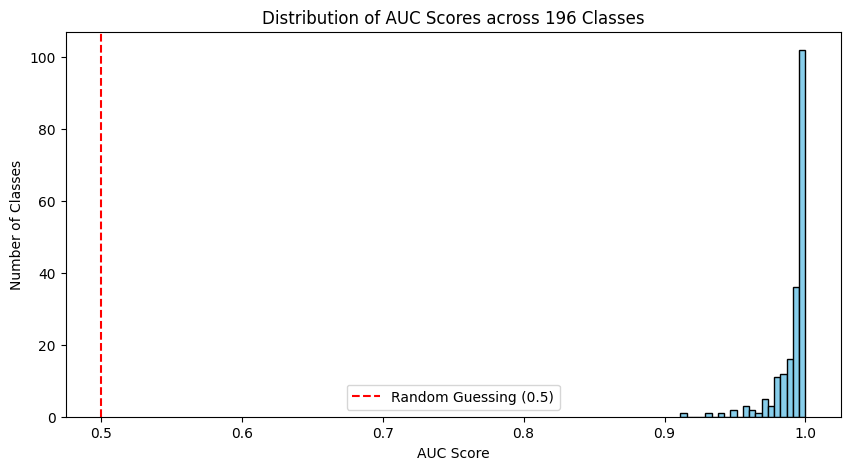

In [16]:
auc_scores = []
for i in range(len(class_names)):
    auc_scores.append((class_names[i], roc_auc[i]))

auc_scores.sort(key=lambda x: x[1], reverse=True)

print("\n" + "="*40)
print("Highest AUC Scores)")
print("="*40)
for name, score in auc_scores[:10]:
    print(f"{score:.4f} | {name}")

print("\n" + "="*40)
print("Lowest AUC Scores")
print("="*40)
for name, score in auc_scores[-10:]:
    print(f"{score:.4f} | {name}")

plt.figure(figsize=(10, 5))
plt.hist([score for name, score in auc_scores], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of AUC Scores across 196 Classes')
plt.xlabel('AUC Score')
plt.ylabel('Number of Classes')
plt.axvline(x=0.5, color='red', linestyle='--', label='Random Guessing (0.5)')
plt.legend()
plt.show()


Highest AUC Scores (Best Performing Classes)
1.0000 | Aston Martin Virage Convertible 2012
1.0000 | Bentley Mulsanne Sedan 2011
1.0000 | Chevrolet Express Cargo Van 2007
1.0000 | Chrysler Town and Country Minivan 2012
1.0000 | Dodge Dakota Club Cab 2007
1.0000 | Fisker Karma Sedan 2012
1.0000 | Ford Ranger SuperCab 2011
1.0000 | Ford Fiesta Sedan 2012
1.0000 | GMC Terrain SUV 2012
1.0000 | Geo Metro Convertible 1993

Lowest AUC Scores (Worst Performing Classes)
0.9638 | Suzuki Aerio Sedan 2007
0.9608 | Hyundai Veracruz SUV 2012
0.9600 | Suzuki SX4 Hatchback 2012
0.9582 | Rolls-Royce Phantom Sedan 2012
0.9564 | BMW X3 SUV 2012
0.9510 | Buick Verano Sedan 2012
0.9481 | BMW 1 Series Convertible 2012
0.9420 | Jeep Compass SUV 2012
0.9298 | Aston Martin V8 Vantage Coupe 2012
0.9112 | Ford Mustang Convertible 2007

AUC Statistics
Mean AUC:   0.9911
Median AUC: 0.9958
Std Dev:    0.0128
Min AUC:    0.9112
Max AUC:    1.0000

Performance Distribution:
  Excellent (≥0.90): 196 classes
  Good (

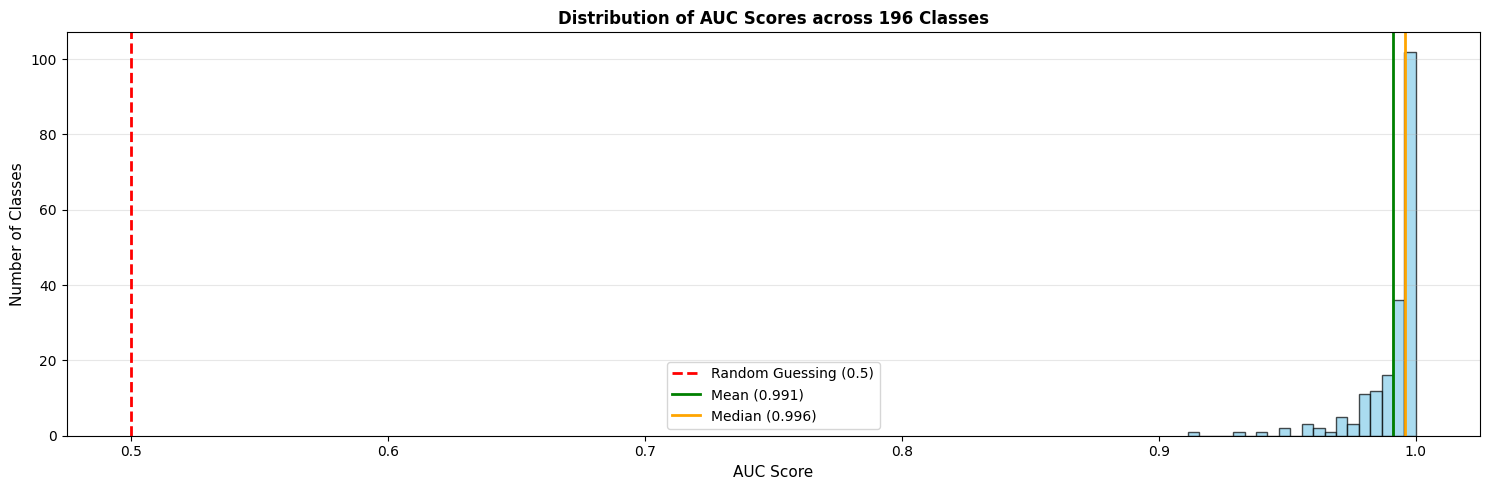

In [17]:
import matplotlib.pyplot as plt
import numpy as np

auc_scores = []
for i in range(len(class_names)):
    auc_scores.append((class_names[i], roc_auc[i]))

auc_scores.sort(key=lambda x: x[1], reverse=True)

print("\n" + "="*50)
print("Highest AUC Scores (Best Performing Classes)")
print("="*50)
for name, score in auc_scores[:10]:
    print(f"{score:.4f} | {name}")

print("\n" + "="*50)
print("Lowest AUC Scores (Worst Performing Classes)")
print("="*50)
for name, score in auc_scores[-10:]:
    print(f"{score:.4f} | {name}")

# Calculate summary statistics
auc_values = [score for name, score in auc_scores]
mean_auc = np.mean(auc_values)
median_auc = np.median(auc_values)
std_auc = np.std(auc_values)

print("\n" + "="*50)
print("AUC Statistics")
print("="*50)
print(f"Mean AUC:   {mean_auc:.4f}")
print(f"Median AUC: {median_auc:.4f}")
print(f"Std Dev:    {std_auc:.4f}")
print(f"Min AUC:    {min(auc_values):.4f}")
print(f"Max AUC:    {max(auc_values):.4f}")

# Count classes by performance level
excellent = sum(1 for score in auc_values if score >= 0.9)
good = sum(1 for score in auc_values if 0.8 <= score < 0.9)
fair = sum(1 for score in auc_values if 0.7 <= score < 0.8)
poor = sum(1 for score in auc_values if score < 0.7)

print(f"\nPerformance Distribution:")
print(f"  Excellent (≥0.90): {excellent} classes")
print(f"  Good (0.80-0.89):  {good} classes")
print(f"  Fair (0.70-0.79):  {fair} classes")
print(f"  Poor (<0.70):      {poor} classes")

# Visualization
plt.figure(figsize=(15, 5))

# Histogram
plt.hist(auc_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random Guessing (0.5)')
plt.axvline(x=mean_auc, color='green', linestyle='-', linewidth=2, label=f'Mean ({mean_auc:.3f})')
plt.axvline(x=median_auc, color='orange', linestyle='-', linewidth=2, label=f'Median ({median_auc:.3f})')
plt.title(f'Distribution of AUC Scores across {len(class_names)} Classes', fontsize=12, fontweight='bold')
plt.xlabel('AUC Score', fontsize=11)
plt.ylabel('Number of Classes', fontsize=11)
plt.legend()
plt.grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.show()